In [19]:
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error,mean_squared_error 
# from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator # needed for integer only on axis
from matplotlib.lines import Line2D # for creating the custom legend
import seaborn as sns

import pandas as pd

#from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

## Introduction
When we evaluate a machine learning model, our primary goal is to have a better sense of how the model's performance will (or will not) extrapolate to future cases. In many industry settings, it is possible to first evaluate model's performance on existing data (i.e., "offline evaluation"). Provided that the model performance is acceptable, we can then deploy the model into a production environment. We can then evaluate the model's performance in the production setting (i.e., "online evaluation") and compare that to the metrics we obtained during the offline evaluation. Ideally, the model's offline accuracy is pretty close to it's online accuracy (though this is [not always the case](http://kops.uni-konstanz.de/bitstream/handle/123456789/31055/Beel_0-285617.pdf?sequence=1)). If not, we can keep updating the model until it achieves the performance we are aiming for.

For academic research, we often do not have the opportunity to deploy models into a live environments. Instead, our analyses are constrained to offline evaluations. We then publish results in conference papers and journals. As a result, it is especially important that our evaluation methods are well-thought through since we likely will not have an opportunity to iterate through model variations and update our estimates of model accuracy. 

In this workshop, I will give an introductory overview of evaluation metrics, paradigms, and pitfalls to help you to construct valid evaluation strategies. 

## Part I: Metrics

### Classification Metrics
**Accuracy** is the number of correct predictions divided by the total number of predictions made

<br/><br/>

$$\text{Accuracy} = \frac{\text{# Correct Predictions}}{\text{Total # of Predictions}}$$

<br/><br/>

Imagine that we are trying to build a model to filter out spam email. The following data contains the text of email messages along with their actual type (i.e., label). "Ham" messages constitute real email messages whereas "spam" messages are, well, spam.  

In [ ]:
#Data from https://github.com/PacktPublishing/Machine-Learning-with-R-Third-Edition
spam_ham = pd.read_csv('sms_spam.csv')
spam_ham = spam_ham[['type']]
spam_ham.head()

If we have a quick look at the type column, we can see that most messages are ham.

In [ ]:
counts_df = spam_ham [['type']].groupby(['type']).size().reset_index(name='outcome_counts')

counts_df['percentage'] = counts_df['outcome_counts'] / counts_df['outcome_counts'].sum()

counts_df

In [ ]:
t= np.zeros(spam_ham.size)
t.size

Using this data, we can build a very simple classifier, which just predicts the majority class. In other words, the classifier will always predict "ham."  

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
#dummy_clf = DummyClassifier(strategy="stratified")
#Note, by definition, the features are ignored in this model
dummy_clf.fit(np.zeros(spam_ham.size), spam_ham[['type']])
#dummy_clf.fit(spam_ham[['text']], spam_ham[['type']])
dummy_predictions = dummy_clf.predict(np.zeros(spam_ham.size))

accuracy = round(accuracy_score(spam_ham[['type']], dummy_predictions),2)
print(f'Accuracy of majority class model is: {accuracy}')

Judging by overall accuracy alone, we might conclude that the dummy classifier is doing a decent job. But of course, this is is not a good model since it never predicts "spam," which is what we are actually trying to get the model to do correctly.

A **confusion matrix** is used for classification models. It allows us to break down our results in terms of true positives, true negatives, false positives, and false negatives. This gives us a better sense of the kinds of errors our model is making
<br/><br/>

|            | Predicted true | Predicted false |
|------------|----------------|-----------------|
|Actual true | True Positive  | False Negative  |
|Actual false| False Positive | True Negative   |

<br/><br/>

Accordingly, we can reframe our formula for accuracy as

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
<br/><br/>

We can create a confusion matrix from our majority class model

In [ ]:
cm = confusion_matrix(spam_ham[['type']], dummy_predictions)

#need to flip so spam is the positive case
cm = np.flip(cm)


cm_df = pd.DataFrame(cm, 
               columns=['predicted_spam', 'predicted_ham'], 
               index = ['actual_spam', 'actual_ham'])



cm_df

In this case, we'll consider "spam" the positive case since that is what we are trying to detect. So, cases where the model predicted "ham" but the message was actually "spam" are false negatives. We have 747 of these cases.

Because the dummy classifier always predicts "ham," there are no cases where the model predicted "spam" and the actual outcome was "ham;" however, if it had, those would constitute false positives.

Even though our model performed well in terms of overall accuracy, we can see from the confusion matrix that it performed abysmally in terms of false negatives. In machine learning, overall accuracy provides a poor measure of a model's performance when we have a "class imbalance," meaning one label occurs much more frequently than the other(s). 



Often with machine learning, we neither want a model that is too conservative in predicting the positive class nor too aggressive. Two metrics that help us assess this are precision and recall

<br/><br/>
**Precision** captures what proportion of the model's prediction of the positive class actually belong to the positive class 

$$\text{Precision} = \frac{TP}{TP + FP}$$

<br/><br/>

**Recall** captures the proportion of cases that actually belong to the positive class were predicted as positive by the model. 

$$\text{Recall} = \frac{TP}{TP + FN}$$


<br/><br/>
A precise model will only predict the positive class when the example is very likely to be positive. A model that has high recall will capture a large proportion of the actual positive examples. 

We will calculate precision and recall for our dummy classifier, but first we need to do some minor modifications on our predictions to make this possible. If we attempt to calculate these metrics from just the majority class predictions, we'll get into some divide by zero issues for precision since we have no spam predictions. 

I'll demonstrate this below, just to show you. 

In [ ]:
TP = cm_df.loc['actual_spam', 'predicted_spam']
TN = cm_df.loc['actual_ham', 'predicted_ham']
FP = cm_df.loc['actual_ham', 'predicted_spam']
FN = cm_df.loc['actual_spam', 'predicted_ham']

print (f'Precision is {TP/(TP + FP)}')
print (f'Recall is {TP/(TP + FN)}')

Okay. For illustrative purposes, we'll add a few additional observations to our dataset that will allow us to calculate these metrics.

In [ ]:
new_data = pd.DataFrame(['spam', 'spam', 'spam', 'spam', 
                         'spam', 'spam', 'ham', 'ham'], columns=['type'])


new_predictions = np.array(['spam', 'spam', 'spam', 'spam', 
                                'spam', 'spam', 'spam', 'spam'])

new_spam_ham = pd.concat([spam_ham, new_data], ignore_index=True)
new_dummy_predictions = np.append(dummy_predictions, new_predictions)

new_cm = confusion_matrix(new_spam_ham[['type']], new_dummy_predictions)

#need to flip so spam is the positive case
new_cm = np.flip(new_cm)


new_cm_df = pd.DataFrame(new_cm, 
               columns=['predicted_spam', 'predicted_ham'], 
               index = ['actual_spam', 'actual_ham'])



new_cm_df


Our new confusion matrix reveals that we have 6 true positives, 4812 true negatives, 2 false positives, and 747 false negatives. With these, we can now calculate precision and recall.

In [ ]:
TP = new_cm_df.loc['actual_spam', 'predicted_spam']
TN = new_cm_df.loc['actual_ham', 'predicted_ham']
FP = new_cm_df.loc['actual_ham', 'predicted_spam']
FN = new_cm_df.loc['actual_spam', 'predicted_ham']

dc_precision = TP/(TP + FP)
dc_recall = TP/(TP + FN)

print (f'Precision is {dc_precision}')
print (f'Recall is {dc_recall}')


Precision is better than recall. Why is this? We have designed our dummy classifier so that it almost never predicts "spam." The data we added contained only 8 predictions of "spam," 6 of which were correct (6/8 = 0.75). So, when our dummy model does predict the positive class (i.e., "spam"), it does a pretty decent job. It's a reasonably precise model.

What our model does not do well is cover all the actual instances of spam in the dataset. This is captured in our recall measure, which is very low. Again, this is because our model is not capable of capturing (i.e., correctly predicting) most of the actual spam examples.

Precision and recall can tell us a lot about how our model is performing, but it's nice to have a single summary statistic as well. The F1 Score or F-measure, which combines precision and recall using the harmonic mean.

**F1 score** is the harmonic mean of precision and recall. 


$$\text{F}_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$

In [ ]:
dc_F1 = 2* ((dc_precision*dc_recall)/(dc_precision + dc_recall))
print(f'F1 is: {dc_F1}')

Note, we can also calculate all these metrics using the metrics functionality of scikit learn. We just need to convert our classes to binary first.

In [ ]:
new_spam_ham['pos_case'] = np.where(new_spam_ham['type']== 'spam', 1, 0)
new_dummy_predictions_binary = np.where(new_dummy_predictions == "spam", 1,0)
f1_score(new_spam_ham[['pos_case']], new_dummy_predictions_binary)


There are many other metrics for evaluating classification models. Techniques that may be a particular help for visualizing results are precision recall curves or receiver operating characteristic (ROC) curves. You can learn more about these techniques here [INSERT LINK]

### Regression Metrics

So far we have only discussed metrics for evaluating classification models, but of course, there are metrics for evaluating regression models as well. Several metrics that are commonly used include mean absolute error, mean squared error, and root mean squared error. In the formulas below, $y_i$ is the actual value for observation i and $\hat{y}_i$ is the predicted value for observation i

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$
 
**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$





## Evaluation Paradigms

In [ ]:
#Add in explanation of overfitting? https://www.quora.com/What-is-an-intuitive-explanation-of-over-fitting-particularly-with-a-small-sample-set-What-are-you-essentially-doing-by-over-fitting-How-does-the-over-promise-of-a-high-R%C2%B2-low-standard-error-occur/answer/Jessica-Su

Thus far, we have discussed evaluation without diving into which data metrics are calculated on. In machine learning, we train a model on one dataset with the goal of making accurate predictions in another dataset. In other words, we aim to create a model that has good generalization. Our evaluation metrics should ideally give us a good sense of how well our model would perform on new data. We will explore several different strategies for training and evaluating models that have different implications for generalization (some good and some not so good).

First, let's load some new data. 


In [2]:
nba = pd.read_csv('nba_player_statistics.csv')
nba.head()

,ast,stl,blk,tov,pf,pts,name,position,team
0,1.941176,0.917647,0.229412,1.088235,2.023529,11.088235,Wesley Matthews,SG,LAL
1,1.133333,0.233333,0.050000,0.516667,0.950000,2.650000,Justin Robinson,PG,OKC
2,1.071429,0.414286,0.128571,0.500000,1.171429,5.057143,Rodney McGruder,SG,DET
3,0.200000,0.172727,0.072727,0.327273,0.990909,1.554545,Anthony Gill,PF,WAS
4,0.825000,0.300000,0.850000,0.600000,1.800000,4.725000,Goga Bitadze,C,IND


The data we will be using for the next section of the workshop contains statistics for NBA players, drawn from www.basketball-reference.com, albeit in modified form $^{ref num}$. The data reflects players' per-season averages for several key metrics. As an example, if a player averaged 10 points per game in their first season, and 20 points per game in their second season, their per-season average points per game is 15. 

The per-season average statistics we will be using are the following:

* **AST** - Assists
* **BLK** - Blocks
* **PF** - Personal Fouls
* **PTS** - Points
* **STL** - Steals
* **TOV** - Turnovers

Using these statistics, we will use KNN classification to predict players' positions. We already provided an introduction to the KNN algorithm in the first day of the Introduction to ML Series, but as a quick refresher, the overarching idea in KNN is that for each example we want to classify, we take the *k* examples whose features are most similar to the new example, and apply whatever label the majority of them have. To determine which examples are most similar, we calculate the distance between the example we are trying to classify and all other examples in our dataset. We often use the Euclidean distance for this, though some other distances are sometimes used. The following formula captures the Euclidean distance for two points *p* and *q*:

$$d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$$

The data from www.basketball-reference.com classifies players positions as point guard (PG), shooting guard (SG), power forward (PF), small forward (SF), and center (C). For simplicity, we will collapse those into three categories: guards, forwards, and centers. We'll map those to numeric values in our dataset such that centers=0, forwards=1, and guards=2. 

In [12]:
# map positions to numbers
nba['pos_num'] = nba.position.map({'C':0, 'SF':1, 'PF':1, 'SG':2, 'PG':2})

To create the model, we'll be using the `scikit-learn` library. To train a model, we'll need to separate out our feature columns (i.e., the basketball stats) from our labels (i.e., the player's position).

In [13]:
#create feature data set
X = nba[['ast', 'stl', 'blk', 'tov', 'pf', 'pts']]

# create response vector (y)
y = nba.pos_num


Let's take a look at the number of players that fall into each position category:

In [ ]:
count_df = nba[['pos_num']].groupby(['pos_num']).size().reset_index(name='outcome_counts')
count_df['proportion'] = count_df['outcome_counts']/sum(count_df['outcome_counts'])
count_df.head()

As with the spam and ham data we started with, we have a class imbalance in our labels. It is not nearly as severe, but still worth bearing in mind as we calculate our model performance metrics!

Before we begin fitting our model, we need transform our features so that they exist on the same scale. Why is this the case? Well, first, let's have a quick look at the data:

In [ ]:
# feature plotting
sns.set(style='white',font_scale=1.5, rc={'figure.figsize':(30,20)})
X.hist(bins=20,color='darkblue' )

The range of some of the features is much larger than others. When we're using KNN, we classify examples using their distance to other examples. If some features have a much large range than others, they will tend to dominate this distance calculation, minimizing the impact of features with smaller ranges. For our algorithm, we'll make use of the `StandardScaler` class in `scikit-learn`, and it's default scaling method, which is [z-scoring](https://en.wikipedia.org/wiki/Standard_score). Note that in the cell below, scaling has been performed across all of our input data. This is not advisable, but I will come back to that in a bit. 

In [14]:

#https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)
X_scale.shape

(447, 6)

### Train on all the data

One method for fitting and evaluating models would be to develop a model that is maximally accurate on our entire dataset and report the accuracy as calculated on all the data. This is known as training accuracy because we are evaluating the model on the same data we used to train the model. Let's look at a few examples. Let's start with a model that uses the top 10 nearest neighbors to classify each example.

In [ ]:
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=10)

# train the model on the entire dataset
knn.fit(X_scale, y)

# store the predicted response values
y_pred_class = knn.predict(X_scale)

print (accuracy_score(y, y_pred_class))

In terms of overall training accuracy, this is a decent model. But can we make it even better? Let's try with a smaller k...


In [ ]:
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=5)

# train the model on the entire dataset
knn.fit(X_scale, y)

# store the predicted response values
y_pred_class = knn.predict(X_scale)

print (accuracy_score(y, y_pred_class))

And an EVEN SMALLER k...

In [ ]:
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=1)

# train the model on the entire dataset
knn.fit(X_scale, y)

# store the predicted response values
y_pred_class = knn.predict(X_scale)

print (accuracy_score(y, y_pred_class))

We have obtained PERFECT accuracy. Yay! Just kidding, this isn't actually a good thing. Intuitively, it probably makes sense to you that this is an unrealistically optimistic estimate of our model's future performance. In the case of *k*=1, the model is able to obtain perfect accuracy because when we use every example to fit the model, the nearest neighbor to every example is itself:

$$d(p,p)=0$$

By fitting our model on all our data and evaluating performance on this same dataset, we have created a model that captures our training data perfectly, but is unlikely to generalize to new data. 

To provide a visual representation of this, let's look at three plots that show the relationship between the decision boundaries. A decision boundary, is a surface that separates data points belonging to different class lables.
<!-- https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html -->

In [ ]:
#from mlxtend.plotting import plot_decision_regions
neighbors = 25
#clf = SVC(C=100,gamma=0.0001)
pca = PCA(n_components = 2)
X2 = pca.fit_transform(X_scale)

# X2 = X_scale[:, 4:6]
knn = KNeighborsClassifier(n_neighbors=neighbors)
knn.fit(X2, y)
# plot_decision_regions(X2, y.values, clf=knn, legend=1)

# # plt.xlabel(X.columns[0], size=14)
# # plt.ylabel(X.columns[1], size=14)
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.title(f'KNN Decision Region Boundary, k={neighbors}', size=16)

AMY: Convert so that all this plotting code is imported from a .py file. It's too much to have in the notebook

In [ ]:
x=X2

# create the x0, x1 feature
x0 = x[:,0]
x1 = x[:,1]

PAD = 1.0 # how much to "pad" around the min/max values. helps in setting bounds of plot
H = 0.1 # mesh stepsize
PROB_DOT_SCALE = 40 # modifier to scale the probability dots
PROB_DOT_SCALE_POWER = 3 # exponential used to increase/decrease size of prob dots
TRUE_DOT_SIZE = 50 # size of the true labels

x0_min, x0_max = np.round(x0.min())-PAD, np.round(x0.max()+PAD)
x1_min, x1_max = np.round(x1.min())-PAD, np.round(x1.max()+PAD)

x0_axis_range = np.arange(x0_min,x0_max, H)
x1_axis_range = np.arange(x1_min,x1_max, H)

xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)

# check the shape of the meshgrid
print('xx0.shape:', xx0.shape)
print('xx1.shape:', xx1.shape)

xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))
print('xx.shape:', xx.shape)

In [ ]:
clf=knn
# prediction of all the little dots
yy_hat = clf.predict(xx) 

# probability of each dot beingthe predicted color
yy_prob = clf.predict_proba(xx) 
                               
# the size of each probability dot
yy_size = np.max(yy_prob, axis=1) 

In [ ]:
font = {'size'   : 10}

plt.rc('font', **font)

# make figure
plt.style.use('seaborn-whitegrid') # set style because it looks nice
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10), dpi=150)

# establish colors and colormap
#  * color blind colors, from https://bit.ly/3qJ6LYL
redish = '#d73027'
orangeish = '#fc8d59'
yellowish = '#fee090'
blueish = '#4575b4'
colormap = np.array([redish,blueish,orangeish])

# plot all the little dots, position defined by the xx values, color
# defined by the knn predictions (yy_hat), and size defined by the 
# probability of that color (yy_prob)
ax.scatter(xx[:,0], xx[:,1], c=colormap[yy_hat], alpha=0.4, 
           s=PROB_DOT_SCALE*yy_size**PROB_DOT_SCALE_POWER, linewidths=0,)

# plot the contours
ax.contour(x0_axis_range, x1_axis_range, 
           np.reshape(yy_hat,(xx0.shape[0],-1)), 
           levels=3, linewidths=1, 
           colors=[redish,blueish, blueish,orangeish,])

# plot the original x values.
# * zorder is 3 so that the dots appear above all the other dots 
ax.scatter(x[:,0], x[:,1], c=colormap[y], s=TRUE_DOT_SIZE, zorder=3, 
           linewidths=0.7, edgecolor='k')

# create legends
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

ax.set_ylabel("PC1")
ax.set_xlabel("PC2")
ax.set_title(f"Decision Boundary for $k$={neighbors}")

# create class legend
# Line2D properties: https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html
# about size of scatter plot points: https://stackoverflow.com/a/47403507/9214620
legend_class = []
for bball_positions, color in zip(['Center', 'Forward', 'Guard'], [blueish, redish, orangeish]):
    legend_class.append(Line2D([0], [0], marker='o', label=bball_positions,ls='None',
                               markerfacecolor=color, markersize=np.sqrt(TRUE_DOT_SIZE), 
                               markeredgecolor='k', markeredgewidth=0.7))

# iterate over each of the probabilities to create prob legend
prob_values = [0.4, 0.6, 0.8, 1.0]
legend_prob = []
for prob in prob_values:
    legend_prob.append(Line2D([0], [0], marker='o', label=prob, ls='None', alpha=0.8,
                              markerfacecolor='grey', 
                              markersize=np.sqrt(PROB_DOT_SCALE*prob**PROB_DOT_SCALE_POWER), 
                              markeredgecolor='k', markeredgewidth=0))



legend1 = ax.legend(handles=legend_class, loc='center', 
                    bbox_to_anchor=(1.15, 0.35),
                    frameon=False, title='class')

legend2 = ax.legend(handles=legend_prob, loc='center', 
                    bbox_to_anchor=(1.15, 0.65),
                    frameon=False, title='prob', )

ax.add_artist(legend1) # add legend back after it disappears

ax.set_yticks(np.arange(x1_min,x1_max, 1)) # I don't like the decimals
ax.grid(False) # remove gridlines (inherited from 'seaborn-whitegrid' style)

# only use integers for axis tick labels
# from: https://stackoverflow.com/a/34880501/9214620
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# remove first ticks from axis labels, for looks
# from: https://stackoverflow.com/a/19503828/9214620
ax.set_xticks(ax.get_xticks()[1:-1])
ax.set_yticks(np.arange(x1_min,x1_max, 1)[1:])

# set the aspect ratio to 1, for looks
ax.set_aspect(1)

# plt.savefig('knn.svg',dpi=300,format='svg', bbox_inches = "tight")
# plt.savefig('knn.png',dpi=150,bbox_inches = "tight")
plt.show()

Thus, we need a better way to estimate the out-of-sample performance of our model, both so that we have a (more) realistic estimate of how our model will perform and so that we can choose a reasonable value for *k*. 

### Train/Test Splits
One alternative approach is to partition your dataset into two subsets. You train your model on one subset (ie., the training set) and evaluate your model in the other (i.e., the test set). The model's performance on the test set is referred to as the **testing accuracy** because we are evaluating the model on an (in theory) independent dataset that was not used during model training. For this reason, testing accuracy is usually a better estimate of out-of-sample performance than training accuracy.

We can use the built-in functionality in scikit learn to split our data into training and testing sets. 

In [ ]:
# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=98, test_size=0.20)

# STEP 2: Create a scaler, fit to the TRAINING data and apply to train and test
scaler = StandardScaler()
# # Fit only on X_train
scaler.fit(X_train)

# # Scale both X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# STEP 2: train the model on the training set (using K=1)
knn = KNeighborsClassifier(n_neighbors=1)

#AMY ADD IN SCALING
knn.fit(X_train, y_train)

# STEP 3: test the model on the testing set, and check the accuracy
y_pred_class = knn.predict(X_test)
print (accuracy_score(y_test, y_pred_class))


In [ ]:
#Repeat for different value of k
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print (accuracy_score(y_test, y_pred_class))


#### Comparing testing accuracy with null accuracy
Null accuracy is the accuracy that could be achieved by always predicting the most frequent class. It is a benchmark against which you may want to measure your classification model.

In [ ]:
len(y_train)

In [ ]:
k_range = range(1, 50)
training_error = []
testing_error = []

for k in k_range:

    # instantiate the model with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)

    # calculate training error
    knn.fit(X_scale, y)
    y_pred_class = knn.predict(X_scale)
    training_accuracy = accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # calculate testing error
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_test)
    testing_accuracy = accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)


In [ ]:
plt.style.use('fivethirtyeight')

In [ ]:
# create a DataFrame of K, training error, and testing error
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

In [ ]:
# plot the relationship between K (HIGH TO LOW) and TESTING ERROR
df.plot(y='testing error')
plt.xlabel('Value of K for KNN')
plt.ylabel('Error (lower is better)')

In [ ]:
# find the minimum testing error and the associated K value
df.sort_values('testing error', ascending=True).head()

When using KNN on this dataset with these features, the best value for K is likely to be around 12.
Given the statistics of an unknown player, we estimate that we would be able to correctly predict his position about 72% of the time

In [ ]:
# plot the relationship between K (from k=50 to k=1) and both training and testing error
df.plot()
plt.gca().invert_xaxis()
plt.xlabel('Value of K for KNN')
plt.ylabel('Error (lower is better)')
plt.show()

In [ ]:
scaler = StandardScaler()
# # Fit only on X_train
scaler.fit(X)

Making predictions on out-of-sample data
Given the statistics of a (truly) unknown player, how do we predict his position?

In [ ]:
# # instantiate the model with the best known parameters
# knn = KNeighborsClassifier(n_neighbors=14)

# # re-train the model with X and y (not X_train and y_train) - why?
# knn.fit(X, y)

# # make a prediction for an out-of-sample observation
# #Amy, need to scale features
# knn.predict([1, 1, 0, 1, 2])

Disadvantages of train/test split?
What would happen if the train_test_split function had split the data differently? Would we get the same exact results as before?

In [ ]:
# try different values for random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=96)
# STEP 2: Create a scaler, fit to the TRAINING data and apply to train and test
scaler = StandardScaler()
# # Fit only on X_train
scaler.fit(X_train)

# # Scale both X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print (accuracy_score(y_test, y_pred_class))


Other topics still to be integrated:
* Leakage
* Overfitting to the test data
* Cross-validation

Testing accuracy is a high-variance estimate of out-of-sample accuracy
K-fold cross-validation overcomes this limitation and provides more reliable estimates
But, train/test split is still useful because of its flexibility and speed

Alternative idea: Train/test split

Split the dataset into two pieces, so that the model can be trained and tested on different data
Testing accuracy is a better estimate than training accuracy of out-of-sample performance
But, it provides a high variance estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

<font size="1">

**Notes on source material**
    
* This evaluation paradigms section of the workshop notebook is takes sections, some nearly verbatim, from [this notebook](https://github.com/justmarkham/DAT8/blob/master/notebooks/09_model_evaluation.ipynb) because it contains a great explaination of evaluation paradigms. Some material was also adapted from maykulkarni's machine learning notebooks repo [https://github.com/maykulkarni], and other parts were adapted from [this tutorial](https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/). Parts of the cross-validation section are adapted from [this notebook](https://github.com/justmarkham/DAT8/blob/master/notebooks/13_cross_validation.ipynb) 
    
* The rad decision boundariy plot was adapted from [this post](https://www.tvhahn.com/posts/beautiful-plots-decision-boundary/)

* The NBA data for the KNN example was generated using the [basketball reference scraper repo](https://github.com/vishaalagartha/basketball_reference_scraper) to scrape NBA statistics from the website https://www.basketball-reference.com. Source data extracted using this repo were transformed into their current format by adapting code from [this tutorial](https://towardsdatascience.com/simple-modeling-of-nba-positions-using-the-k-nearest-neighbors-machine-learning-algorithm-223b8addb08f) on KNN. You can access my complete code for generating the data [here](https://github.com/amywinecoff/baskeball-scraper/blob/main/get_basketball_data.ipynb). I apologize in advance for the chaos of this repo.
</font> 

### K-fold cross validation

#### Steps for K-fold cross-validation
* Split the dataset into K equal partitions (or "folds").
* Use fold 1 as the testing set and the union of the other folds as the training set. 
* Calculate testing accuracy.
* Repeat steps 2 and 3 K times, using a different fold as the testing set each time.
* Use the average testing accuracy as the estimate of out-of-sample accuracy.
* Diagram of 5-fold cross-validation:

![title](cross_validation_diagram.png)

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)

In [7]:
# create the range 1 to 25
rn = range(1,26)

In [9]:
for train_index, test_index in kf.split(rn):
    print(train_index, test_index)

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] [0 1 2 3 4]
[ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] [5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24] [10 11 12 13 14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24] [15 16 17 18 19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [20 21 22 23 24]


In [ ]:
#https://towardsdatascience.com/complete-guide-to-pythons-cross-validation-with-examples-a9676b5cac12

In [21]:

#clf = svm.SVC(kernel='linear', C=1, random_state=42)
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=12)
scores = cross_val_score(knn, X_scale, y, cv=5)
print(f"accuracy scores per fold are {scores}")
print("%0.2f average accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

accuracy scores per forld are [0.74444444 0.75555556 0.62921348 0.64044944 0.66292135]
0.69 average accuracy with a standard deviation of 0.05


In [4]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.model_selection import cross_validate

decision_tree_result = cross_validation(knn, X_scale, y, 5)
# kf = KFold(25, n_folds=5, shuffle=False)

# # print the contents of each training and testing set
# print ('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
# for iteration, data in enumerate(kf, start=1):
#     print ('{:^9} {} {:^25}'.format(iteration, nba_data[0], nba_data[1]))

NameError: name 'cross_validation' is not defined

Dataset contains 25 observations (numbered 0 through 24)
5-fold cross-validation, thus it runs for 5 iterations
For each iteration, every observation is either in the training set or the testing set, but not both
Every observation is in the testing set exactly once


Comparing cross-validation to train/test split
Advantages of cross-validation:

More accurate estimate of out-of-sample accuracy
More "efficient" use of data (every observation is used for both training and testing)
Advantages of train/test split:

Runs K times faster than K-fold cross-validation
Simpler to examine the detailed results of the testing process
Cross-validation recommendations
K can be any number, but K=10 is generally recommended
For classification problems, stratified sampling is recommended for creating the folds
Each response class should be represented with equal proportions in each of the K folds
scikit-learn's cross_val_score function does this by default
Cross-validation example: parameter tuning
Goal: Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset

In [ ]:
from sklearn.cross_validation import cross_val_score


In [ ]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print scores

In [22]:
# search for an optimal value of K for KNN
k_range = range(1, 31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scale, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print (k_scores)

[0.6242929292929293, 0.6305555555555555, 0.6663131313131313, 0.6934343434343435, 0.6774242424242424, 0.6753030303030304, 0.67989898989899, 0.6978282828282829, 0.6778787878787879, 0.6755555555555555, 0.6957070707070707, 0.6866161616161617, 0.6777777777777777, 0.7023737373737373, 0.6688888888888889, 0.6708080808080809, 0.6665151515151515, 0.6731313131313132, 0.6776262626262627, 0.6888383838383839, 0.6798989898989898, 0.6686363636363636, 0.6663636363636363, 0.6686363636363637, 0.6730303030303031, 0.6774747474747475, 0.6841414141414142, 0.6752020202020202, 0.6752020202020202, 0.6730808080808082]


Text(0, 0.5, 'Cross-Validated Accuracy')

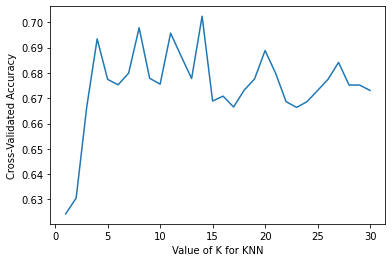

In [23]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

Cross-validation example: model selection
Goal: Compare the best KNN model with logistic regression on the iris dataset

In [25]:
# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=12)
print (cross_val_score(knn, X_scale, y, cv=10, scoring='accuracy').mean())

0.6866161616161617


In [26]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print (cross_val_score(logreg, X_scale, y, cv=10, scoring='accuracy').mean())

0.709040404040404


### Other options with cross-validation

**Repeated cross-validation**

Repeat cross-validation multiple times (with different random splits of the data) and average the results. This creates a more reliable estimate of out-of-sample performance by reducing the variance associated with a single trial of cross-validation

**Creating a hold-out set**

"Hold out" a portion of the data before beginning the model building process
Locate the best model using cross-validation on the remaining data, and test it using the hold-out set
More reliable estimate of out-of-sample performance since hold-out set is truly out-of-sample